# Project - Fourth Requirement

### Include packages.

In [127]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from copy import deepcopy

### Environment

Let's define some types of non-stationary environments...

In [128]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

With sinusoidally-varying "true value".

In [129]:
class PricingEnvironmentMultiProductSinusoidalMean:
    def __init__(self, cost_vector, initial_mean_valuations, std_valuations, buyers_per_round, total_rounds, amplitudes, periods):
        # Initialize the environment
        self.cost_vector = np.array(cost_vector)  
        self.initial_mean_valuations = np.array(initial_mean_valuations)
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round  
        self.total_rounds = total_rounds
        self.current_round = 0

        # Each product has its own amplitude and period for the sinusoidal valuation
        self.amplitudes = np.array(amplitudes)
        self.periods = np.array(periods)

    def round(self, p_t_vector):
        # Define the valuations for each product at the current round
        mean_valuations = self.initial_mean_valuations + self.amplitudes * np.sin(2 * np.pi * self.current_round / self.periods)

        # Sample sales
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy) 
        
        # Compute the reward and go on
        reward = ( np.array(p_t_vector) - self.cost_vector ) * num_sales
        self.current_round += 1
        return num_sales, reward

### Now define the setting...

In [130]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 10               # Independent trials

# --- Pricing Grid and Product Info ---

cost_vector = np.array([2.0, 2.5, 3.0])             # Costs per product
initial_values = np.array([5.0, 6.0, 5.5])          # Initial mean valuations
std_valuations = np.array([1.0, 1.2, 0.8])          # Std for each product

min_p = 0.0
max_p = int(np.max(initial_values) * 2)

K = 10
P = np.linspace(min_p, max_p, K)                    # Shared price grid for all products

assert np.all(cost_vector < initial_values), "Each cost must be less than its initial valuation"

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory

amplitudes = np.array([2.0, 1.5, 1.0])
periods = np.array([1000, 1500, 800])

buyers_per_round = 50                               # Number of buyers per round

# --- Other Parameters ---

zoom_end = 2 * max(periods)     # Show only up to 2x the max period in main plots
zoom_end_mini = 200             # Show only up to 200 rounds in mini plots
zoom_end_5 = 5000               # Start zooming 5k rounds
s = 30                          # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

### Design our agent

In [131]:
class EXP3P:
    def __init__(self, num_actions, gamma, eta, max_reward_scale):
        self.num_actions = num_actions
        self.gamma = gamma
        self.eta = eta
        self.weights = np.ones(num_actions)
        self.probabilities = np.zeros(num_actions)
        # Safe upper bound on absolute reward
        self.max_reward_scale = max_reward_scale

    def choose_action(self):
        sum_weights = np.sum(self.weights)
        self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + (self.gamma / self.num_actions)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.num_actions, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Normalize reward and compute loss
        normalized_reward = observed_reward / self.max_reward_scale
        loss_t = (1 - normalized_reward) / 2
        estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)

        # Normalize weights if needed
        w_sum = np.sum(self.weights)
        if w_sum < 1e-100 or w_sum > 1e100:
            self.weights /= np.max(self.weights)

class PrimalDualMultiProductPricingAgent:
    def __init__(self, prices, B, T, cost_vector, buyers_per_round, initial_lambda=0, learning_rate_lambda=0.01, exp3p_gamma=0.1, exp3p_eta=None):
        self.prices = prices
        self.K = len(prices) # Number of price options
        self.N = len(cost_vector) # Number of products

        self.B = B # Total budget
        self.T = T # Total time horizon
        self.cost_vector = np.array(cost_vector)
        self.buyers_per_round = buyers_per_round
        self.rho = B / T if T > 0 else 1e-8 # Initial target average sales per round
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        self.current_round = 0
        self.remaining_budget = B

        # Determine a safe upper bound for reward scaling for EXP3P
        max_possible_sales_per_product = buyers_per_round
        max_possible_profit_per_product_per_round = (np.max(prices) - np.min(cost_vector)) * max_possible_sales_per_product
        self.max_reward_scale = max_possible_profit_per_product_per_round + (np.max(self.prices) * 2) * self.buyers_per_round
        if self.max_reward_scale == 0:
            self.max_reward_scale = 1.0

        # Init leargning rate in case not provided
        if exp3p_eta is None:
            exp3p_eta = np.sqrt(2 * np.log(self.K) / (self.K * self.T))
        # Initialize the products' regret minimizers
        self.product_regret_minimizers = [ EXP3P(num_actions=self.K, gamma=exp3p_gamma, eta=exp3p_eta, max_reward_scale=self.max_reward_scale) for _ in range(self.N) ]

        self.history_chosen_price_indices = []
        self.history_lambda = [self.lambda_t]
        self.history_total_sales = []
        self.history_total_rewards = []
        self.history_rho_target = []

    def choose_prices(self):
        chosen_prices = []
        chosen_indices = []
        for i in range(self.N):
            idx = self.product_regret_minimizers[i].choose_action()
            chosen_prices.append(self.prices[idx])
            chosen_indices.append(idx)

        self.history_chosen_price_indices.append(chosen_indices)
        return np.array(chosen_prices), chosen_indices

    def update(self, chosen_indices, sales_vector, rewards_vector):
        total_sales = np.sum(sales_vector)
        self.history_total_sales.append(total_sales)
        self.history_total_rewards.append(np.sum(rewards_vector))
        self.history_rho_target.append(self.rho) # Store current rho for plotting

        # Update the regret minimizers for each product
        for i in range(self.N):
            price = self.prices[chosen_indices[i]]
            cost = self.cost_vector[i]
            num_sales = sales_vector[i]

            rho_per_product = self.rho / self.N
            effective_reward = (price - cost) * num_sales - self.lambda_t * (num_sales - rho_per_product)
            self.product_regret_minimizers[i].update(chosen_indices[i], effective_reward)

        # Update budget
        self.remaining_budget -= total_sales
        self.current_round += 1
        rounds_left = self.T - self.current_round
        self.rho = self.remaining_budget / rounds_left if rounds_left > 0 else 0

        # Lambda update
        diff = total_sales - self.rho
        lambda_update = self.eta_lambda * diff
        self.lambda_t += lambda_update
        self.lambda_t = np.clip(self.lambda_t, 0, np.max(self.prices) * 2)
        self.history_lambda.append(self.lambda_t)

        if self.remaining_budget < 0:
            print(f"Budget exhausted at round {self.current_round}. Total sales: {np.sum(self.history_total_sales)}")
            return False
        return True

### First experiment

Run the simulation

In [132]:
# --- Simulation ---
all_rewards = []        # Shape: (n_trials, T)
all_lambdas = []        # Shape: (n_trials, <=T+1)
all_rho_targets = []    # Shape: (n_trials, <=T)
all_sold_pieces = []    # Shape: (n_trials, <=T)

for seed in range(n_trials):
    np.random.seed(seed)

    # --- Set up environment ---
    env = PricingEnvironmentMultiProductSinusoidalMean(cost_vector=cost_vector, initial_mean_valuations=initial_values, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T, amplitudes=amplitudes, periods=periods)

    # --- Initialize agent ---
    agent = PrimalDualMultiProductPricingAgent(prices=P, B=B, T=T, cost_vector=cost_vector, buyers_per_round=buyers_per_round, initial_lambda=0, learning_rate_lambda=0.001, exp3p_gamma=0.1, exp3p_eta=None)

    rewards_trial = np.zeros(T)
    rho_values_trial = [] # This will be replaced by agent.history_rho_target
    sold_pieces_values_trial = []

    for t in range(T):
        price_vec, idx_vec = agent.choose_prices()
        sales_vec, reward_vec = env.round(price_vec)
        cont = agent.update(idx_vec, sales_vec, reward_vec)

        rewards_trial[t] = np.sum(reward_vec)
        if not cont:
            rewards_trial[t+1:] = 0
            break
        # No longer need to append to rho_values_trial and sold_pieces_values_trial here
        # as they are now stored directly in agent.history_rho_target and agent.history_total_sales
        # (The history_total_sales was already being appended in agent.update)

    all_rewards.append(np.cumsum(rewards_trial))
    all_lambdas.append(agent.history_lambda)
    all_rho_targets.append(agent.history_rho_target)
    all_sold_pieces.append(agent.history_total_sales)

# --- Analysis and Plotting ---

# Cumulative Utility
all_rewards = np.array(all_rewards)  # shape: (n_trials, T)
mean_cum_util = np.mean(all_rewards, axis=0)
std_cum_util = np.std(all_rewards, axis=0)

# Dual variable lambda
all_lambdas_padded = [l + [np.nan] * (T + 1 - len(l)) for l in all_lambdas]
all_lambdas = np.array(all_lambdas_padded)

valid_mask_lambda = ~np.isnan(all_lambdas).all(axis=0)
mean_lambda = np.full(T + 1, np.nan)
std_lambda = np.full(T + 1, np.nan)
mean_lambda[valid_mask_lambda] = np.nanmean(all_lambdas[:, valid_mask_lambda], axis=0)
std_lambda[valid_mask_lambda] = np.nanstd(all_lambdas[:, valid_mask_lambda], axis=0)

# Sold Pieces and Target Rho
# Pad sold_pieces and rho_targets since trials might end early
all_sold_pieces_padded = [s + [np.nan] * (T - len(s)) for s in all_sold_pieces] # Use T as max length
all_sold_pieces = np.array(all_sold_pieces_padded)

# No longer need max_len_rho_targets and all_rho_targets_padded
all_rho_targets_padded = [r + [np.nan] * (T - len(r)) for r in all_rho_targets] # Use T as max length
all_rho_targets = np.array(all_rho_targets_padded)

mean_sold_pieces = np.nanmean(all_sold_pieces, axis=0)
std_sold_pieces = np.nanstd(all_sold_pieces, axis=0)

mean_rho_targets = np.nanmean(all_rho_targets, axis=0)
std_rho_targets = np.nanstd(all_rho_targets, axis=0)

Plot utility

>>> Cumulative utility after 20000 rounds: 436130.13 ± 58530.08


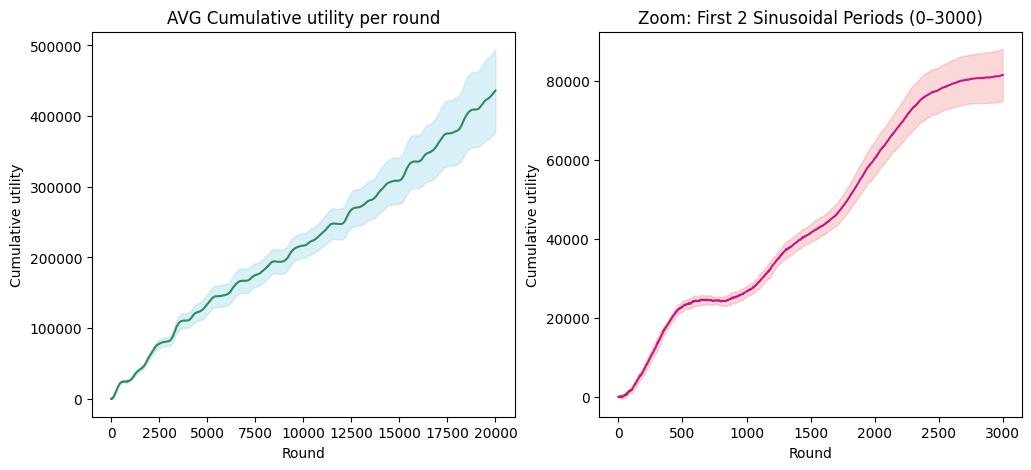

In [133]:
plt.figure(figsize=(12, 5))

# --- Full cumulative utility plot ---
plt.subplot(1, 2, 1)
plt.plot(mean_cum_util, color='seagreen', label='Cumulative utility')
plt.fill_between(np.arange(T), mean_cum_util - std_cum_util, mean_cum_util + std_cum_util, color='skyblue', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
plt.title('AVG Cumulative utility per round')

# --- Zoomed plot for first two periods ---
plt.subplot(1, 2, 2)
plt.plot(np.arange(zoom_end), mean_cum_util[:zoom_end], color='mediumvioletred', label='Zoomed view (first 2 periods)')
plt.fill_between(np.arange(zoom_end), mean_cum_util[:zoom_end] - std_cum_util[:zoom_end], mean_cum_util[:zoom_end] + std_cum_util[:zoom_end], color='lightcoral', alpha=0.3, label='±1 std. dev.')
plt.xlabel('Round')
plt.ylabel('Cumulative utility')
_ = plt.title(f'Zoom: First {2} Sinusoidal Periods (0–{zoom_end})')

print(f">>> Cumulative utility after {T} rounds: {mean_cum_util[-1]:.2f} ± {std_cum_util[-1]:.2f}")